In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, silhouette_score
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import shap

In [101]:
df = pd.read_csv('current_nba_players.csv')
X = df.select_dtypes(include=[np.number])
X = X.drop(columns=['Unnamed: 0', 'jersey', 'weight_lbs','overall','total_attributes'])
features = X.columns
y = df['position_1']
y = y.map({'PG': 0, 'SG': 1, 'SF': 2, 'PF': 3, 'C': 4}).astype('category')
pipe = Pipeline([('scaler', StandardScaler()), ('impute', SimpleImputer(strategy='median'))])
X = pipe.fit_transform(X)

c:\Users\caleb\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


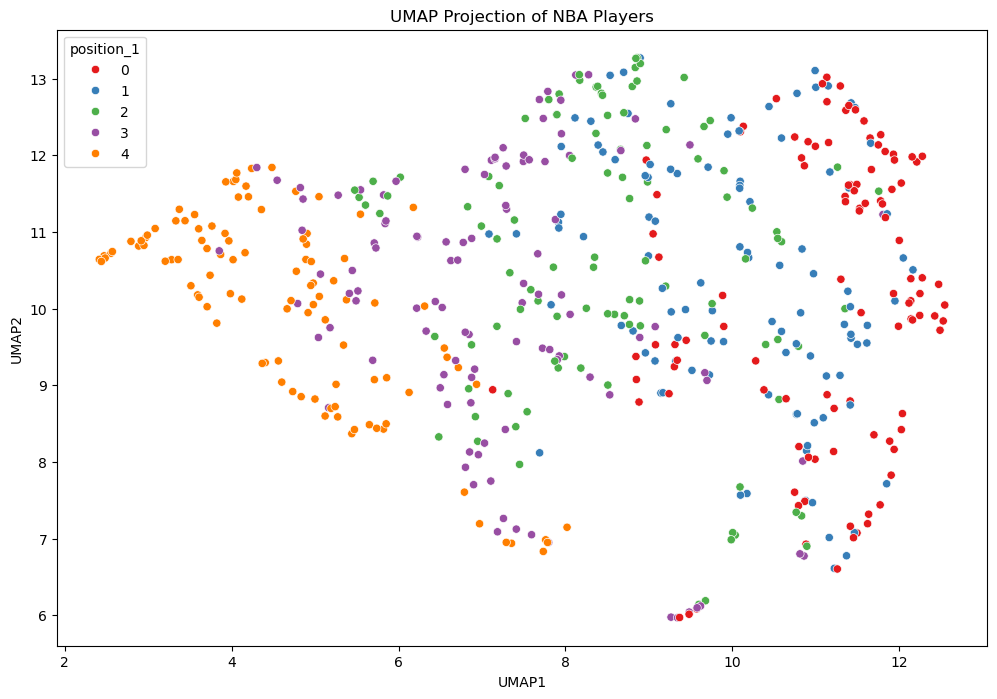

In [102]:
import umap
umap_model = umap.UMAP(n_neighbors=5, n_components=2, random_state=253)
umap_fit = umap_model.fit_transform(X)
X = pd.DataFrame(X)
X['UMAP1'], X['UMAP2'] = umap_fit[:, 0], umap_fit[:, 1]
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue=y, palette='Set1', data=X)
plt.title('UMAP Projection of NBA Players')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

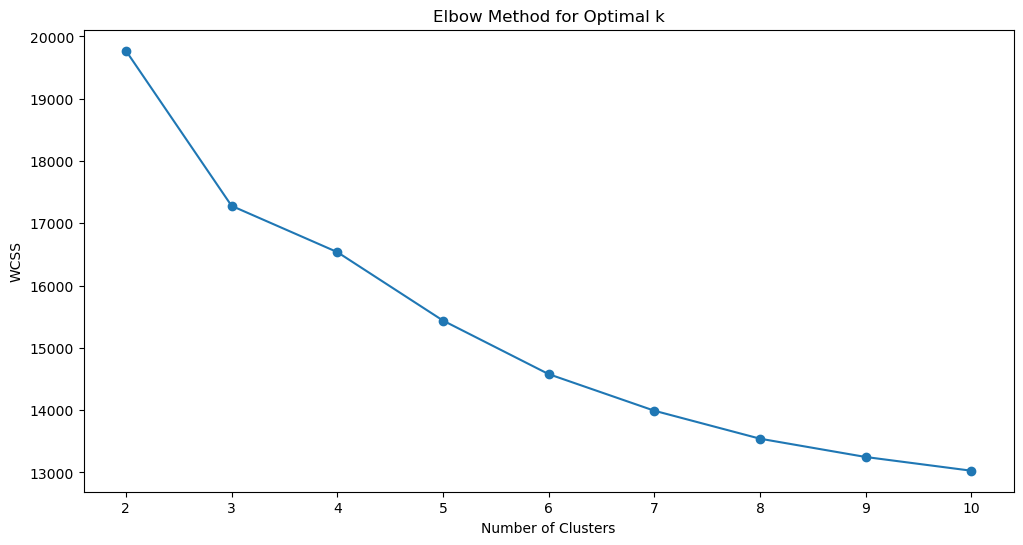

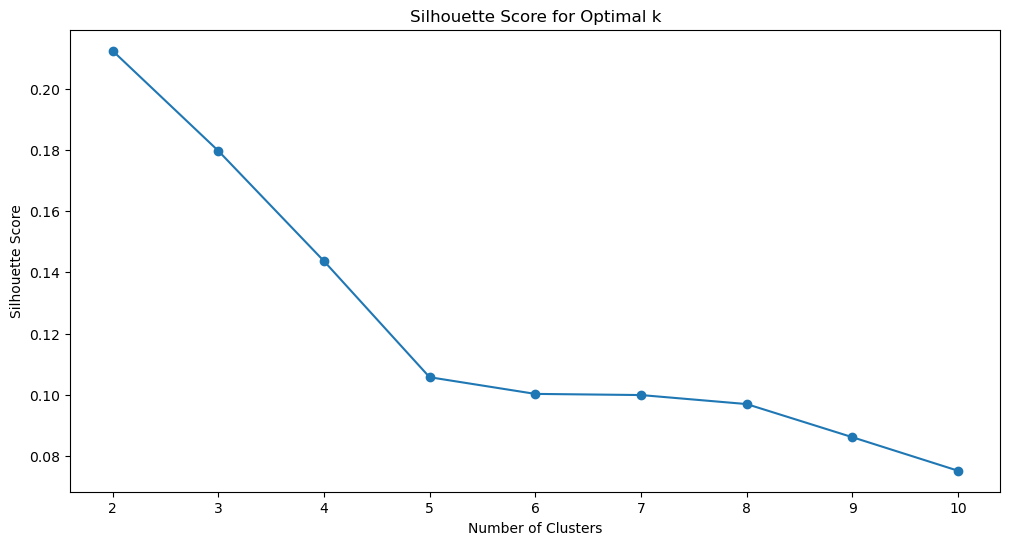

In [103]:
wcss = []
sil_scores = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=253)
    cluster_labels = kmeans.fit_predict(X.drop(columns=['UMAP1', 'UMAP2']))
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X.drop(columns=['UMAP1', 'UMAP2']), cluster_labels))

plt.figure(figsize=(12, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


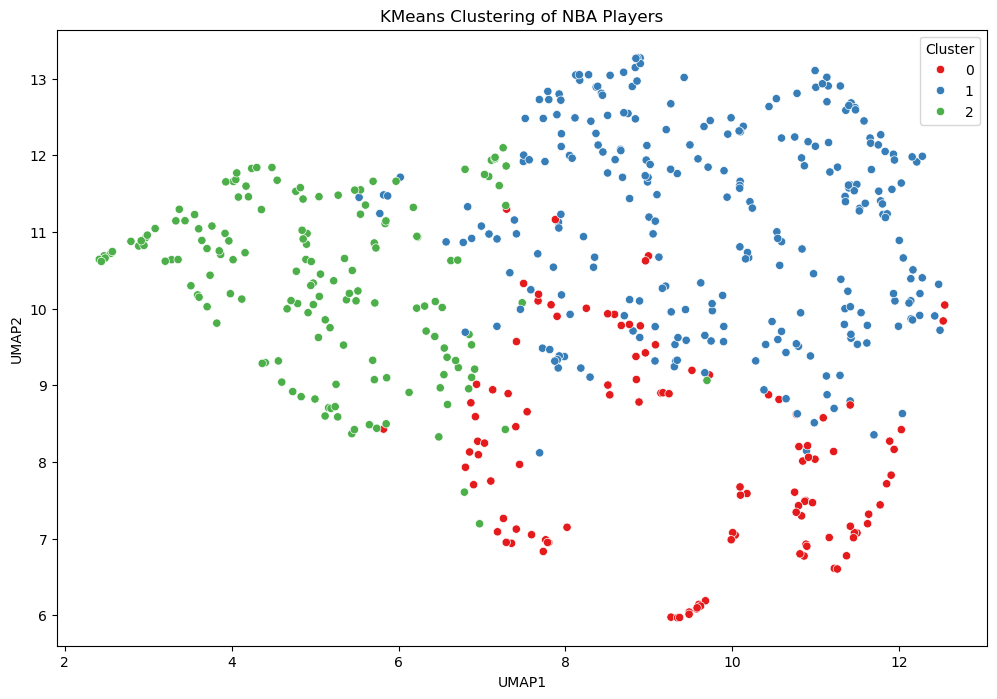

In [104]:
kmeans = KMeans(n_clusters=3, random_state=253)
X["Cluster"] = kmeans.fit_predict(X.drop(columns=['UMAP1', 'UMAP2']))

plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='Set1', data=X)
plt.title('KMeans Clustering of NBA Players')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [105]:
summary_stats = X.drop(columns=['UMAP1', 'UMAP2']).groupby('Cluster').mean()
summary_stats.columns = features
print(summary_stats)


         height_cm  weight_kg  wingspan_cm  season_salary  years_in_the_nba  \
Cluster                                                                       
0        -0.127586  -0.019770    -0.056695       1.016282          0.576893   
1        -0.542308  -0.551325    -0.521252      -0.457021         -0.278610   
2         1.011068   0.948638     0.924285      -0.270900          0.055186   

         group_outside_scoring  close_shot  mid_range_shot  three_point_shot  \
Cluster                                                                        
0                     0.837549    0.621580        0.660990          0.445166   
1                    -0.027960   -0.304374        0.008414          0.250473   
2                    -0.556301    0.067833       -0.490688         -0.745370   

         free_throw  ...     steal     block  help_defense_iq  \
Cluster              ...                                        
0          0.369989  ...  0.437330  0.081494         0.886679   
1       

In [106]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=253)
X['Cluster_GMM'] = gmm.fit(X.drop(columns=['UMAP1', 'UMAP2','Cluster']))

c:\Users\caleb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [107]:
probs = gmm.predict_proba(X.drop(columns=['UMAP1', 'UMAP2','Cluster','Cluster_GMM']))
X['Anomaly_Score'] = np.min(probs, axis=1)

In [108]:
thresh = np.percentile(X['Anomaly_Score'], 1.5)
anomalies = X[X['Anomaly_Score'] < thresh]
print(f"Anomalies detected: {len(anomalies)}")
print(anomalies[['Anomaly_Score', 'Cluster', 'UMAP1','UMAP2']].sort_values(by='Anomaly_Score'))

Anomalies detected: 8
     Anomaly_Score  Cluster      UMAP1      UMAP2
197  7.466731e-149        2   2.554176  10.722417
463  1.236960e-132        0  11.903157   7.828476
127  1.779081e-119        2   3.357971  10.640023
123  4.969804e-116        0  11.494006   7.074416
437  1.548232e-115        2   2.916295  10.884950
59   8.493544e-115        2   5.650402   8.486513
440  6.485076e-112        2   2.793139  10.877287
386  3.102162e-107        2   4.049710  11.682962


In [109]:
print(df.iloc[[197]]['name'])
print(df.iloc[[463]]['name'])
print(df.iloc[[127]]['name'])
print(df.iloc[[123]]['name'])
print(df.iloc[[437]]['name'])
print(df.iloc[[59]]['name'])
print(df.iloc[[440]]['name'])
print(df.iloc[[386]]['name'])

197    Ivica Zubac
Name: name, dtype: object
463    Stephen Curry
Name: name, dtype: object
127    DeAndre Jordan
Name: name, dtype: object
123    De’Aaron Fox
Name: name, dtype: object
437    Robert Williams III
Name: name, dtype: object
59    Brook Lopez
Name: name, dtype: object
440    Rudy Gobert
Name: name, dtype: object
386    N’Faly Dante
Name: name, dtype: object


In [110]:
X2 = df.select_dtypes(include=[np.number])
X2 = X2.drop(columns=['Unnamed: 0', 'jersey', 'weight_lbs','overall','total_attributes'])

scaler = MinMaxScaler()
impute = SimpleImputer(strategy='median')
X2 = scaler.fit_transform(X2)
X2 = impute.fit_transform(X2)
X2 = pd.DataFrame(X2, columns=scaler.get_feature_names_out())

In [111]:
isof = IsolationForest(contamination=0.02, random_state=253)
isof.fit(X2)

IsolationForest(contamination=0.02, random_state=253)

In [112]:
outlier = isof.predict(X2)
n_outliers = np.sum(outlier == -1)
print(f"Number of outliers detected: {n_outliers}")
pct_outliers = n_outliers / len(X2) * 100
print(f"Percentage of outliers detected: {pct_outliers:.2f}%")

Number of outliers detected: 11
Percentage of outliers detected: 2.09%


In [113]:
scores = isof.decision_function(X2)

In [114]:
df['outlier'] = (outlier == -1).astype(int)
df['anomaly_score'] = scores

In [124]:
print(df[df.outlier==1][['name','potential','speed_with_ball','interior_defense']])
print(df['overall'].min())

                      name  potential  speed_with_ball  interior_defense
26           Anthony Davis         96               67                95
127         DeAndre Jordan         75               33                70
175  Giannis Antetokounmpo         98               80                90
233      Jaren Jackson Jr.         88               33                90
255          Jesse Edwards         71               32                62
261            Joel Embiid         98               62                92
336           LeBron James         99               85                79
392           Nikola Jokic         99               60                83
440            Rudy Gobert         87               25                95
509      Victor Wembanyama         99               64                95
525        Zion Williamson         94               74                59
67


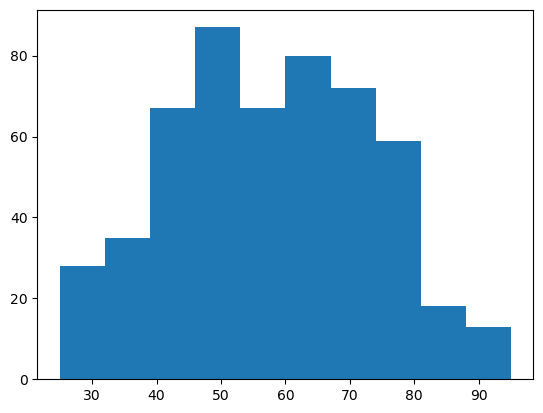

In [129]:
plt.hist(df['interior_defense'])
plt.show()

In [116]:
mod = RandomForestRegressor(random_state=253)
mod.fit(X2, scores)

RandomForestRegressor(random_state=253)

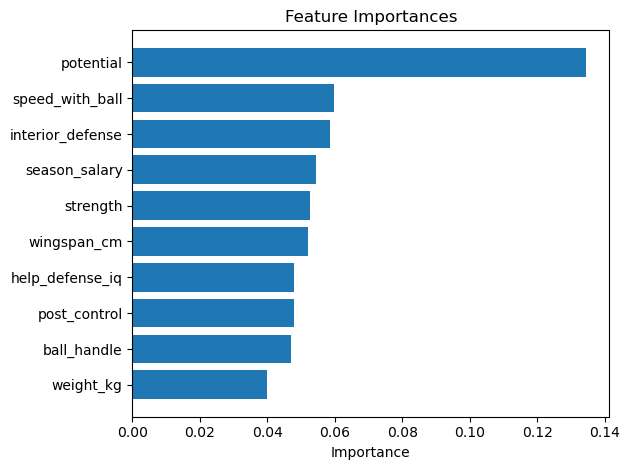

In [117]:
importances = mod.feature_importances_
featuresnames = X2.columns

feat_imp = pd.DataFrame({'Feature': featuresnames, 'Importance': importances}).sort_values(by='Importance', ascending=False)


top_n = 10
feat_imp = feat_imp.head(top_n)

plt.figure
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [118]:
outliers = df[df['outlier'] == 1]

In [133]:
explainer = shap.TreeExplainer(mod, X2)
shap_values = explainer(X2, check_additivity=False)

 98%|===================| 518/526 [00:14<00:00]        

In [134]:
exp = shap.Explanation(shap_values, shap_values.base_values,X2, feature_names=X2.columns)

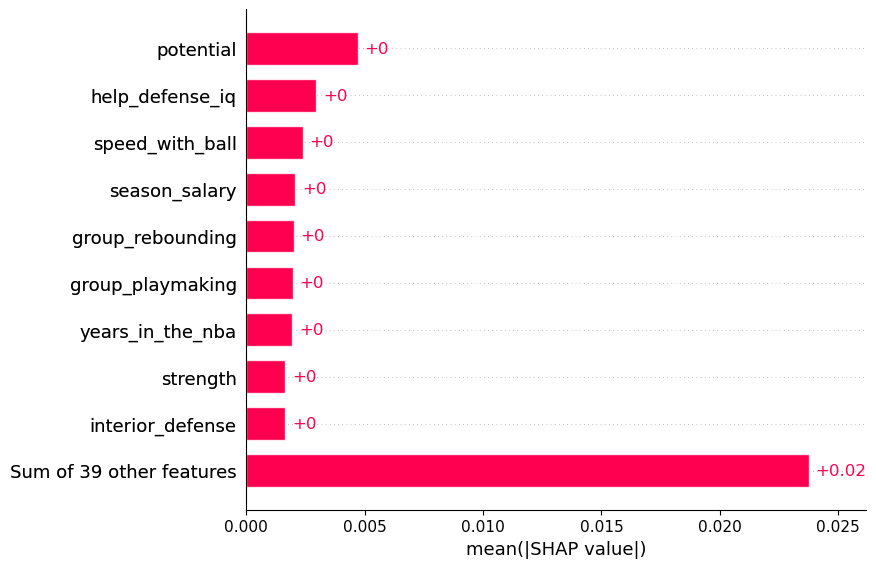

In [135]:
shap.plots.bar(exp, max_display=10)

Outlier: Anthony Davis


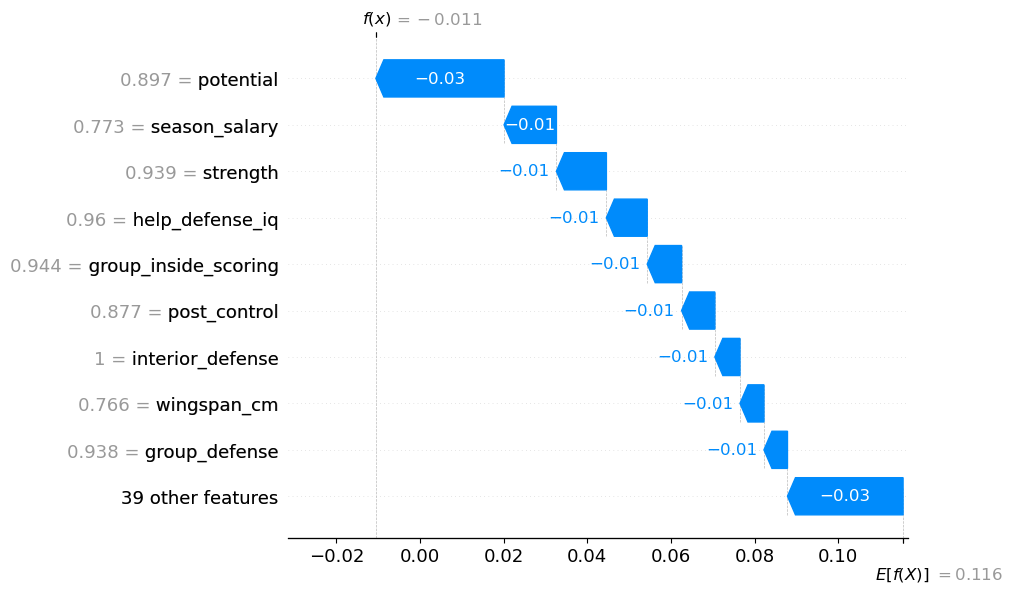



Outlier: DeAndre Jordan


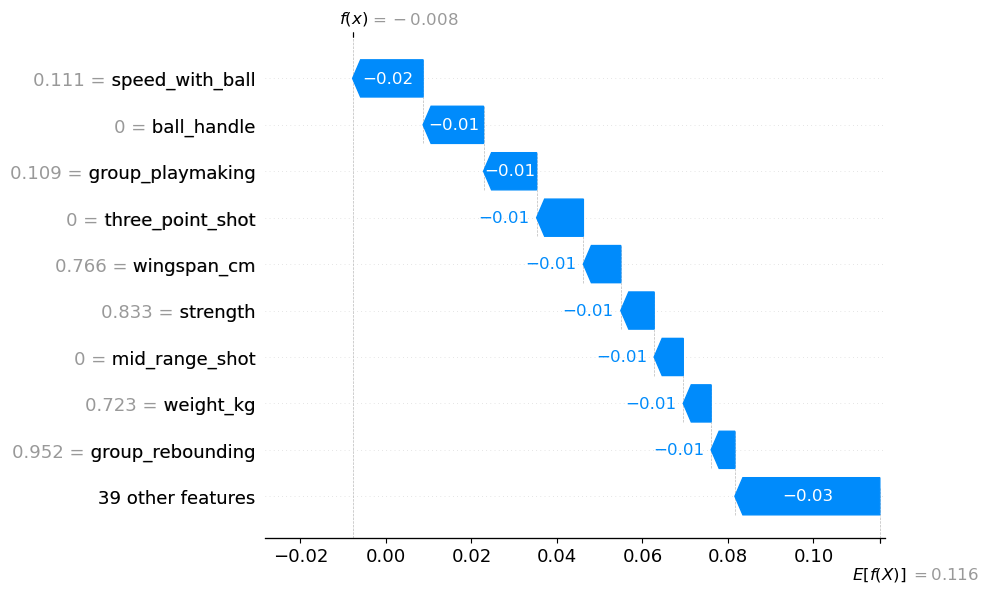



Outlier: Giannis Antetokounmpo


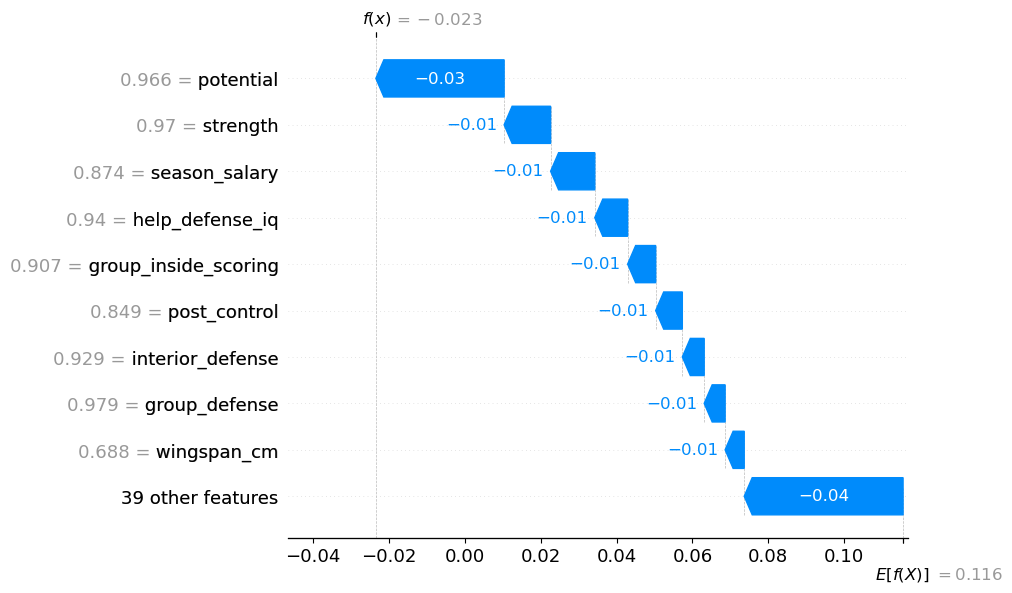



Outlier: Jaren Jackson Jr.


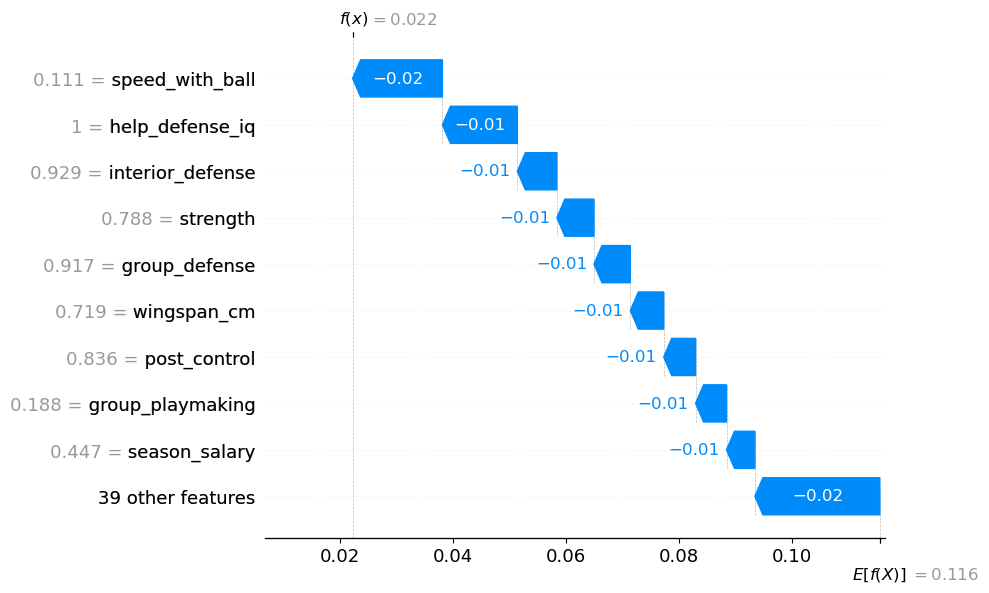



Outlier: Jesse Edwards


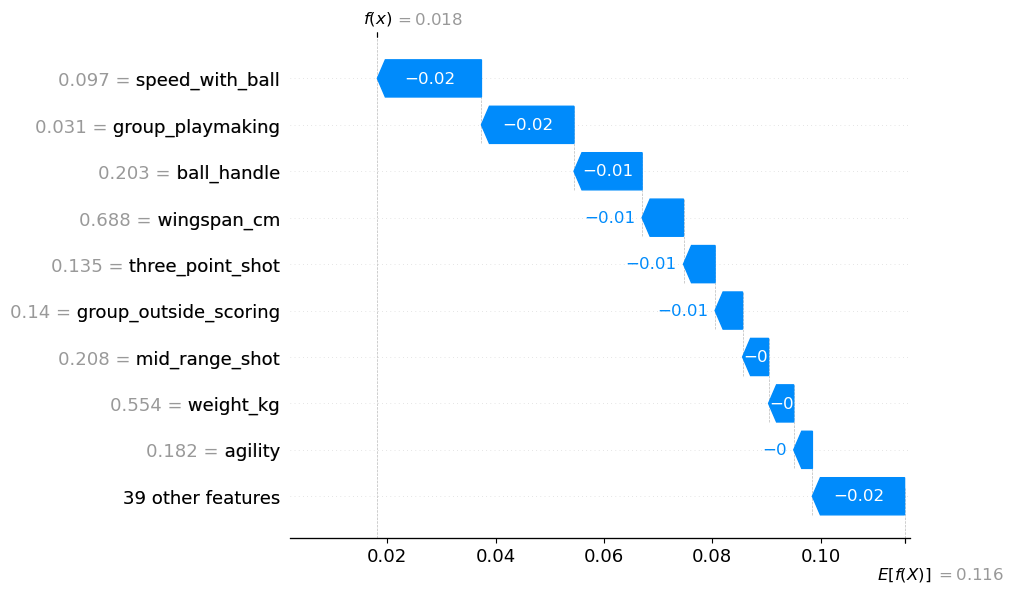



Outlier: Joel Embiid


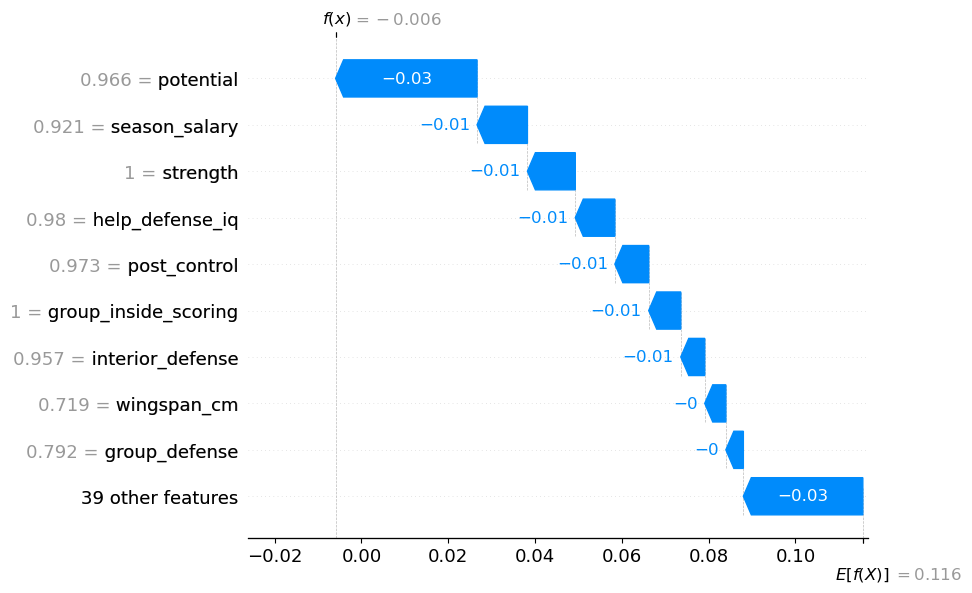



Outlier: LeBron James


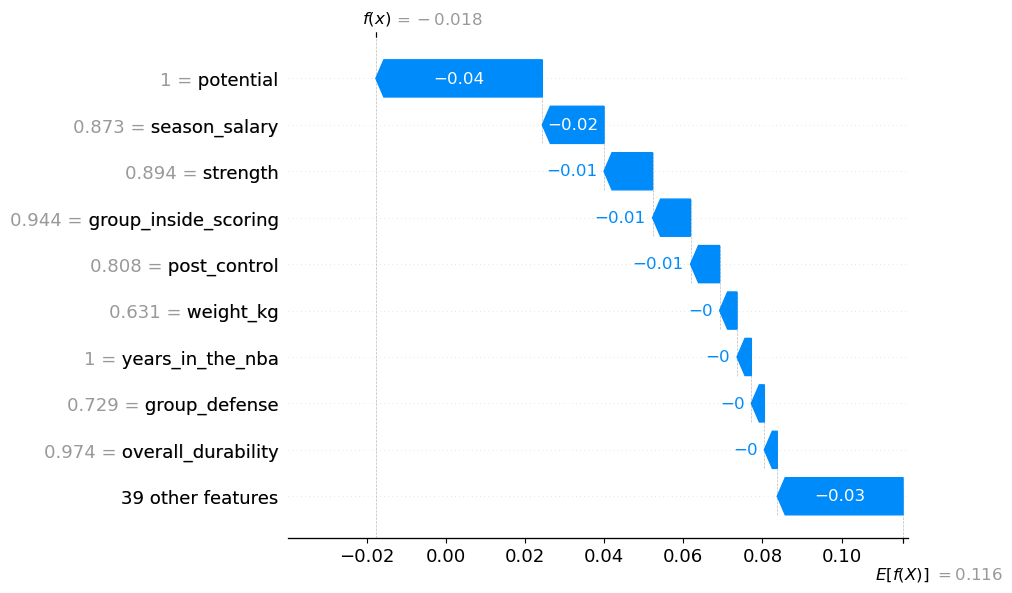



Outlier: Nikola Jokic


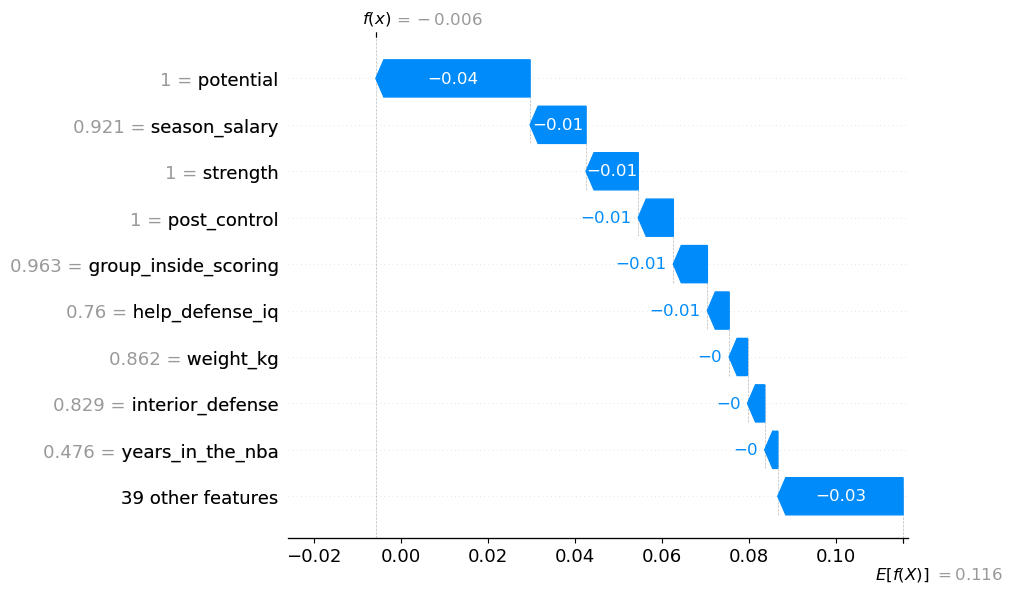



Outlier: Rudy Gobert


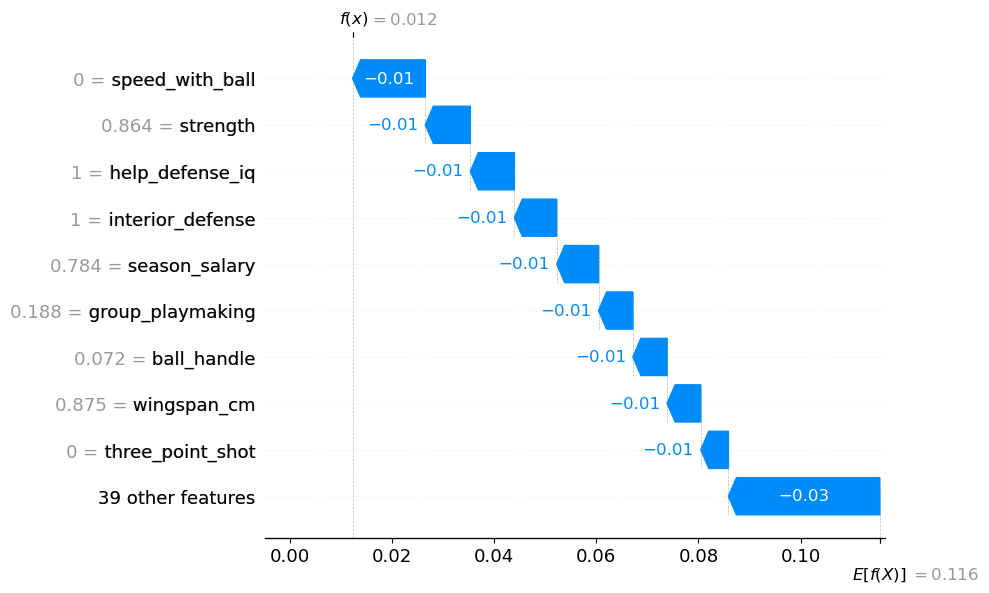



Outlier: Victor Wembanyama


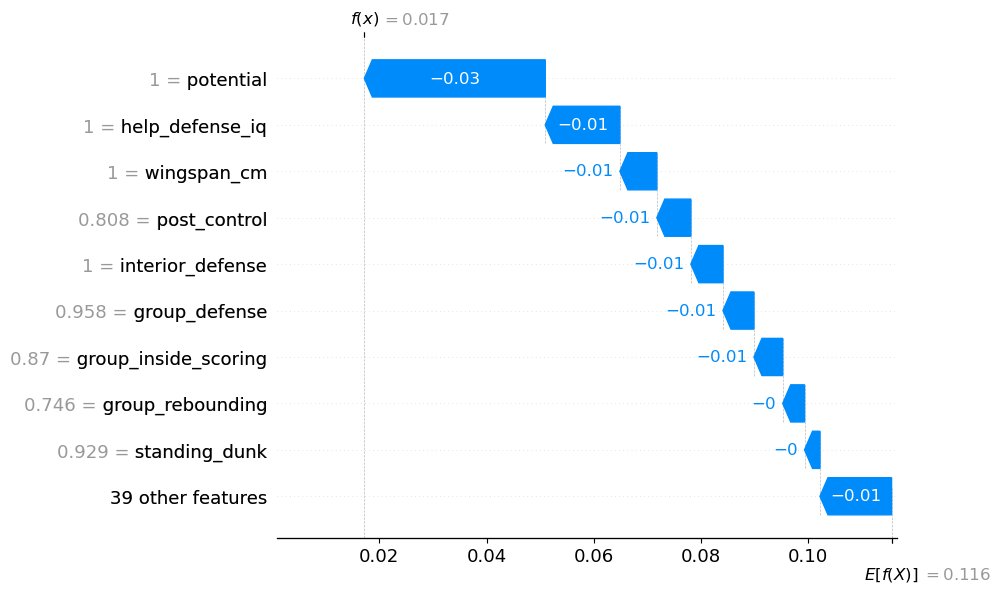



Outlier: Zion Williamson


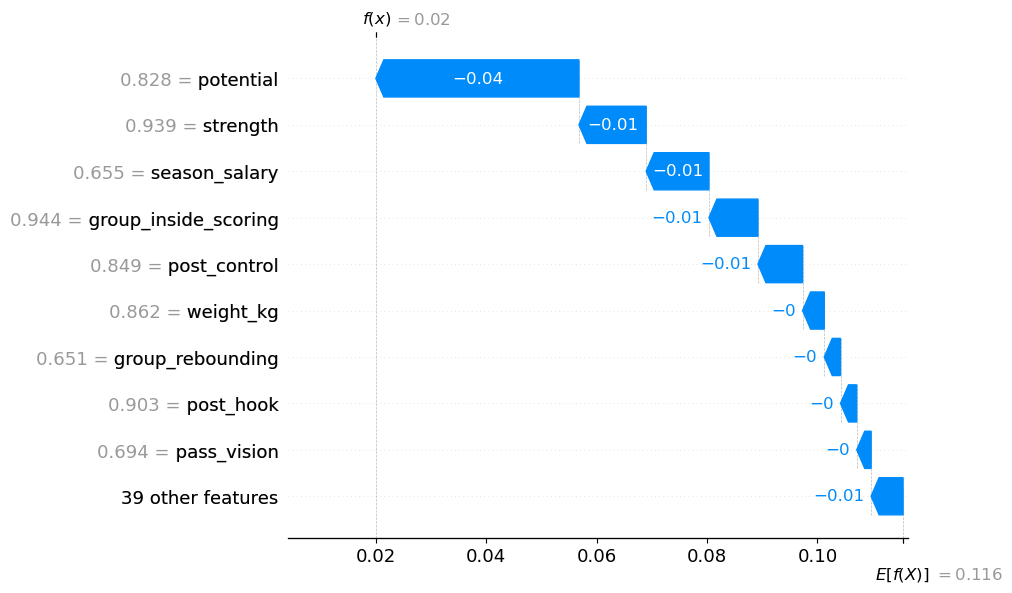

In [136]:
outlierindex = outliers.index
for i in outlierindex:
    print(f"Outlier: {df.iloc[i]['name']}")
    shap.plots.waterfall(exp[i], max_display=10)
    plt.show()
    print("\n")